# SHAP Explainability in Turkish Text Classification

## Imports and Parameters

In [83]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:400%; margin-right:auto; margin-left:0;"
opt.columnDefs = [{"className": "dt-left", "targets": "_all"}]
opt.classes = 'display'
opt.dom = "lti"
opt.column_filters = "footer"
opt.lengthMenu = list(range(3, 250, 50))

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle
import numpy as np

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import shap

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from shap_utils import *
from load_models import prepare_models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_shap = config["path_shap"]
thresholds = config["thresholds"]
only_load = config["only_load"]

path_reports = config["path_reports"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

Parameter  \
0                 path_ttc4900   
1                 path_tr_news   
2              path_interpress   
3                    path_tc32   
4      path_bert_model_ttc4900   
5      path_bert_model_tr_news   
6   path_bert_model_interpress   
7         path_bert_model_tc32   
8       path_tbt_model_ttc4900   
9       path_tbt_model_tr_news   
10   path_tbt_model_interpress   
11         path_tbt_model_tc32   
12                   path_shap   
13                   path_lime   
14                     path_ig   
15                   path_rand   
16              path_attention   
17                path_reports   
18                  thresholds   
19                   only_load   
20                      device   
21         pipeline_parameters   

                                                               Value  
0                                                     Data/TTC_4900/  
1                                                      Data/TR_News/  
2                                                   Data/Interpress/  
3                                                         Data/TC32/  
4             Models/bertturk_text_classification_fine_tuned_ttc4900  
5             Models/bertturk_text_classification_fine_tuned_tr_news  
6          Models/bertturk_text_classification_fine_tuned_interpress  
7                Models/bertturk_text_classification_fine_tuned_tc32  
8      Models/turkishbertweet_text_classification_fine_tuned_ttc4900  
9      Models/turkishbertweet_text_classification_fine_tuned_tr_news  
10  Models/turkishbertweet_text_classification_fine_tuned_interpress  
11        Models/turkishbertweet_text_classification_fine_tuned_tc32  
12                                                    Data/Exp_SHAP/  
13                                                    Data/Exp_LIME/  
14                                                      Data/Exp_IG/  
15                                                    Data/Exp_Rand/  
16                                               Data/Exp_Attention/  
17                                                          Reports/  
18                                                   [0.5, 0.6, 0.7]  
19                                                             False  
20                                                              cuda  
21   {'padding': 'max_length', 'truncation': True, 'batch_size': 16}

## Load Datasets

In [3]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## SHAP Explainability

In [5]:
all_exp_results = pd.DataFrame(columns=["Cl Acc", "ECS FT", "ECS TT", "ORC (+)", "ORC (-)"])

### BERTurk

#### Inference on Full Text

In [6]:
# Load BERTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.


In [7]:
# predict_parameter_set_ttc4900 = {
#     'model': bert_model_ttc4900,
#     'tokenizer': bert_tokenizer_ttc4900,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_ttc4900,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tr_news = {
#     'model': bert_model_tr_news,
#     'tokenizer': bert_tokenizer_tr_news,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_tr_news,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_interpress = {
#     'model': bert_model_interpress,
#     'tokenizer': bert_tokenizer_interpress,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_interpress,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tc32 = {
#     'model': bert_model_tc32,
#     'tokenizer': bert_tokenizer_tc32,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_tc32,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# print("\nClassification metrics of full text prediction of TTC 4900:\n")
# bert_full_text_preds_ttc4900 = evaluate_classification(ttc4900_test, predict_parameter_set_ttc4900, bert_label2id_ttc4900)

# print("\nClassification metrics of full text prediction of TR News:\n")
# bert_full_text_preds_tr_news = evaluate_classification(tr_news_test, predict_parameter_set_tr_news, bert_label2id_tr_news)

# print("\nClassification metrics of full text prediction of Interpress:\n")
# bert_full_text_preds_interpress = evaluate_classification(interpress_test, predict_parameter_set_interpress, bert_label2id_interpress)

# print("\nClassification metrics of full text prediction of TC 32:\n")
# bert_full_text_preds_tc32 = evaluate_classification(tc32_test, predict_parameter_set_tc32, bert_label2id_tc32)

# path_classification_results = "Data/Classification_Results/BERTurk/"

# with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_ttc4900, file)

# with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_tr_news, file)

# with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_interpress, file)

# with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_tc32, file)

In [8]:
path_classification_results = "Data/Classification_Results/BERTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

In [9]:
num_samples = 250

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

#### TTC4900

In [88]:
shap_explainer_ttc4900 = shap.Explainer(bert_pipeline_text_ttc4900)
ttc4900_bert_results = {}

for threshold in thresholds:

    shap_values_ttc, tokens_values_ttc = apply_shap(path_shap, ttc4900_test, 
                                                    f"shap_values_ttc_{threshold}_bert", 
                                                    shap_explainer_ttc4900, 
                                                    len(bert_label2id_ttc4900),
                                                    only_load=only_load)

    top_tokens_ttc4900 = apply_thresholding(tokens_values_ttc, threshold)
    
    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        None,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        id2label=bert_id2label_ttc4900,
                                        device=device)

    ttc4900_bert_results[threshold] = (shap_values_ttc, ttc4900_bert_result)
    
    clear_gpu_memory()
    
show(ttc4900_bert_results[0.5][1])

'shap_values_ttc_0.5_bert' file shape: (250, None, 7)
'shap_values_ttc_0.6_bert' file shape: (250, None, 7)
'shap_values_ttc_0.7_bert' file shape: (250, None, 7)


In [11]:
# sample_no = 4

# shap.plots.text(ttc4900_bert_results[0.7][0][sample_no])
# shap.plots.text(ttc4900_bert_results[0.7][1][sample_no])


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.906
Overall Relative Change (ORC) positive changes      :  5.821 %
Overall Relative Change (ORC) negative changes      : -9.636 %


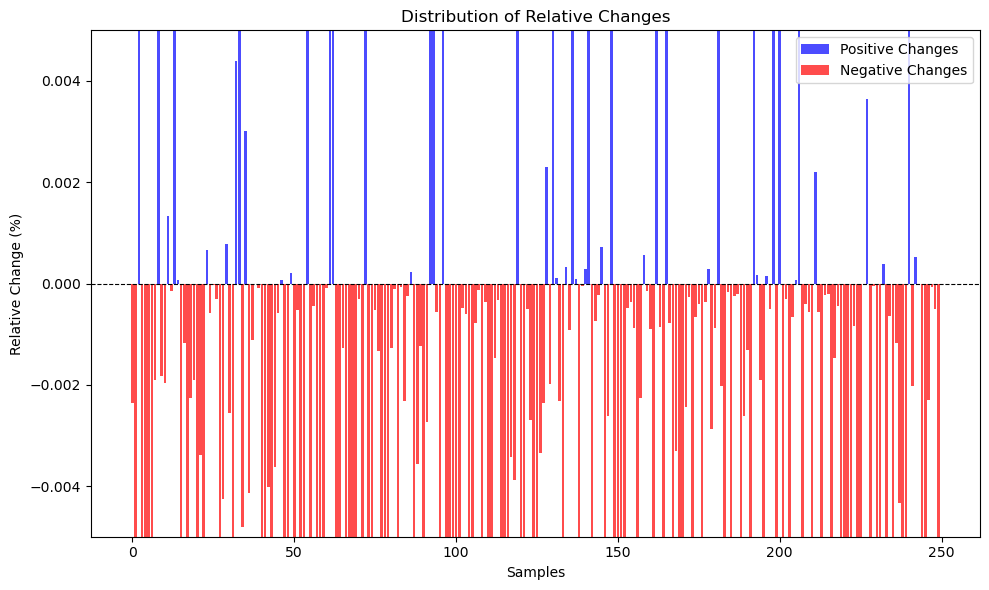


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.915
Overall Relative Change (ORC) positive changes      :  6.002 %
Overall Relative Change (ORC) negative changes      : -8.869 %


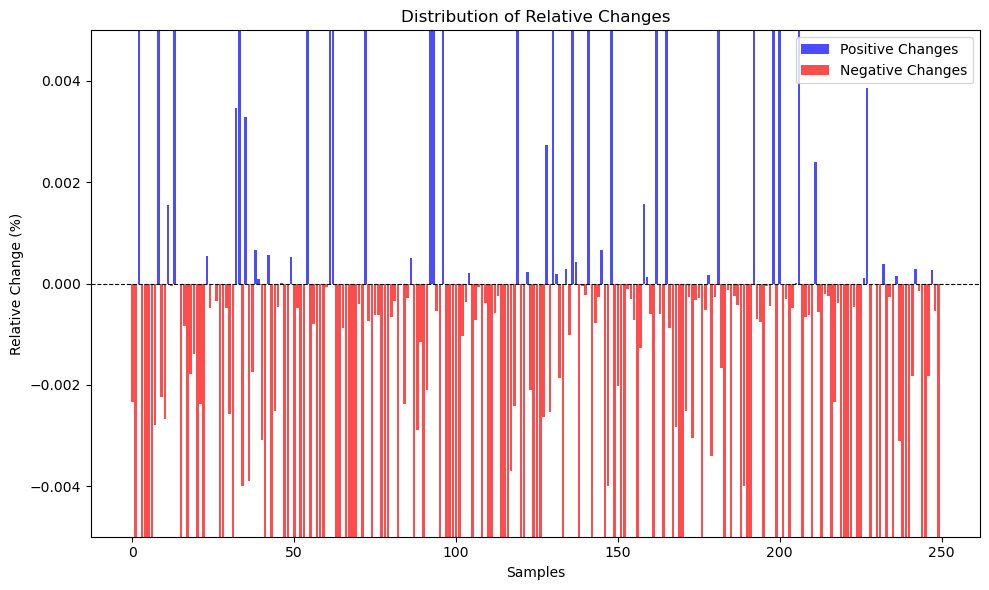


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.973
Explanations Contribution Score (ECS) of Top Tokens :  0.919
Overall Relative Change (ORC) positive changes      :  5.532 %
Overall Relative Change (ORC) negative changes      : -8.622 %


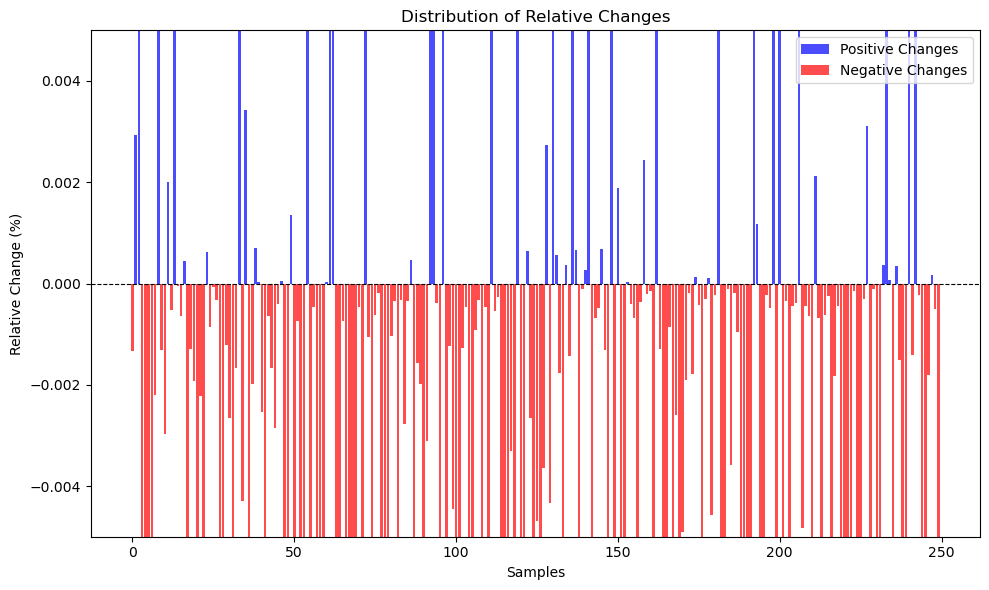

In [12]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [90]:
shap_explainer_tr_news = shap.Explainer(bert_pipeline_text_tr_news)
tr_news_bert_results = {}

for threshold in thresholds:
    
    shap_values_tr_news, tokens_values_tr_news = apply_shap(path_shap, tr_news_test, 
                                                            f"shap_values_tr_news_{threshold}_bert", 
                                                            shap_explainer_tr_news,
                                                            len(bert_label2id_tr_news),
                                                            only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(tokens_values_tr_news, threshold)
    
    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        None,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        id2label=bert_id2label_tr_news,
                                        device=device)

    tr_news_bert_results[threshold] = (shap_values_tr_news, tr_news_bert_result)
    
    clear_gpu_memory()

show(tr_news_bert_results[0.5][1])

'shap_values_tr_news_0.5_bert' file shape: (250, None, 11)
'shap_values_tr_news_0.6_bert' file shape: (250, None, 11)
'shap_values_tr_news_0.7_bert' file shape: (250, None, 11)


In [14]:
# sample_no = 8

# shap.plots.text(tr_news_bert_results[0.5][0][sample_no])
# shap.plots.text(tr_news_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.562
Overall Relative Change (ORC) positive changes      :  11.465 %
Overall Relative Change (ORC) negative changes      : -35.581 %


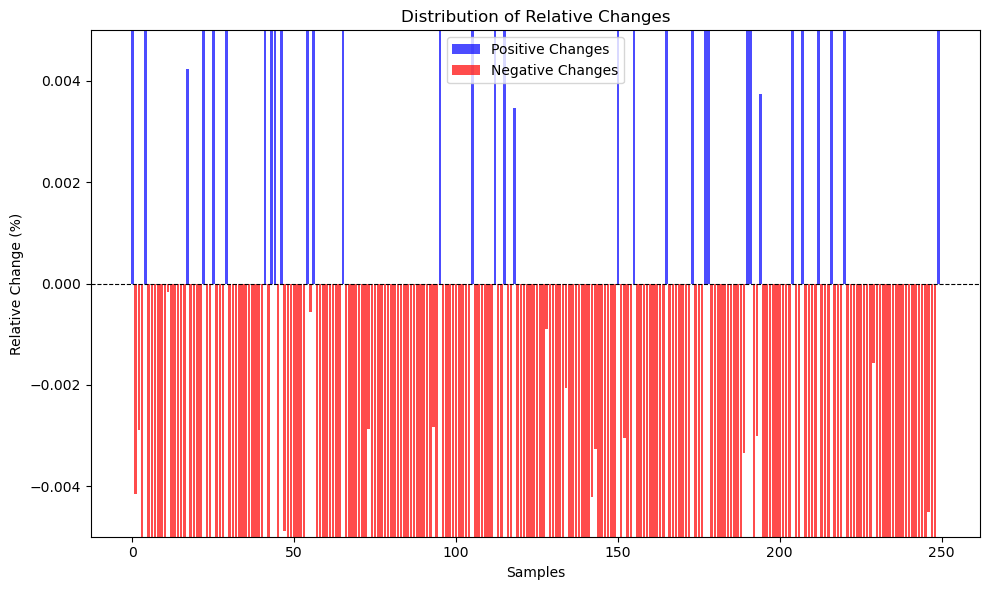


Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.562
Overall Relative Change (ORC) positive changes      :  11.887 %
Overall Relative Change (ORC) negative changes      : -35.431 %


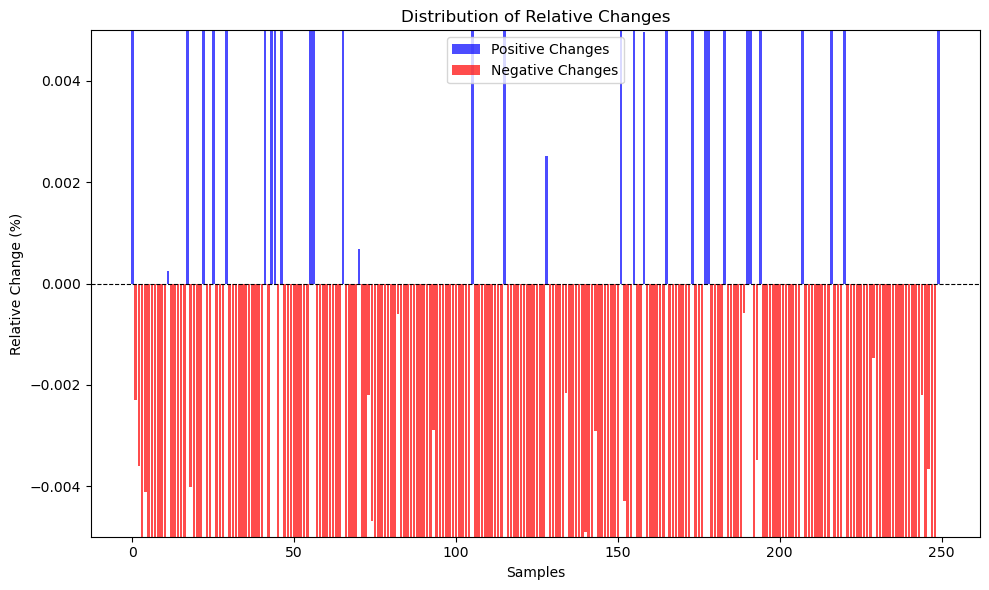


Classification accuracy                             :  0.776
Explanations Contribution Score (ECS) of Full Text  :  0.856
Explanations Contribution Score (ECS) of Top Tokens :  0.541
Overall Relative Change (ORC) positive changes      :  12.502 %
Overall Relative Change (ORC) negative changes      : -37.786 %


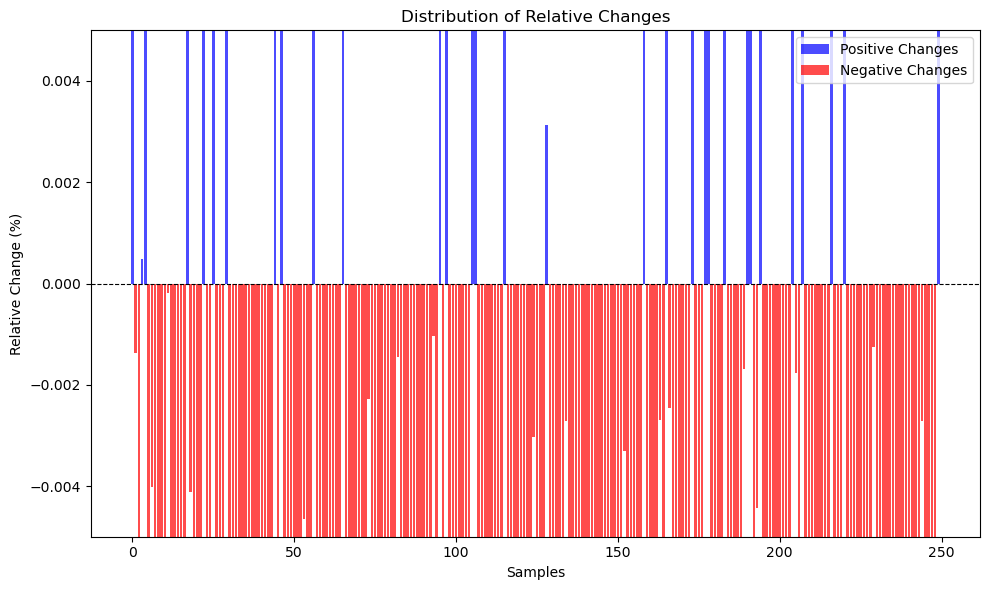

In [15]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [16]:
shap_explainer_interpress = shap.Explainer(bert_pipeline_text_interpress)
interpress_bert_results = {}

for threshold in thresholds:
    
    shap_values_interpress, tokens_values_interpress = apply_shap(path_shap, interpress_test, 
                                                                  f"shap_values_interpress_{threshold}_bert", 
                                                                  shap_explainer_interpress, 
                                                                  len(bert_label2id_interpress),
                                                                  only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(tokens_values_interpress, threshold)

    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           None,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           id2label=bert_id2label_interpress,
                                           device=device)

    interpress_bert_results[threshold] = (shap_values_interpress, interpress_bert_result)
    
    clear_gpu_memory()
    
show(interpress_bert_results[0.5][1])

'shap_values_interpress_0.5_bert' file shape: (250, None, 10)


'shap_values_interpress_0.6_bert' file shape: (250, None, 10)


'shap_values_interpress_0.7_bert' file shape: (250, None, 10)


In [17]:
# sample_no = 10

# shap.plots.text(interpress_bert_results[0.5][0][sample_no])
# shap.plots.text(interpress_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.731
Overall Relative Change (ORC) positive changes      :  8.681 %
Overall Relative Change (ORC) negative changes      : -26.824 %


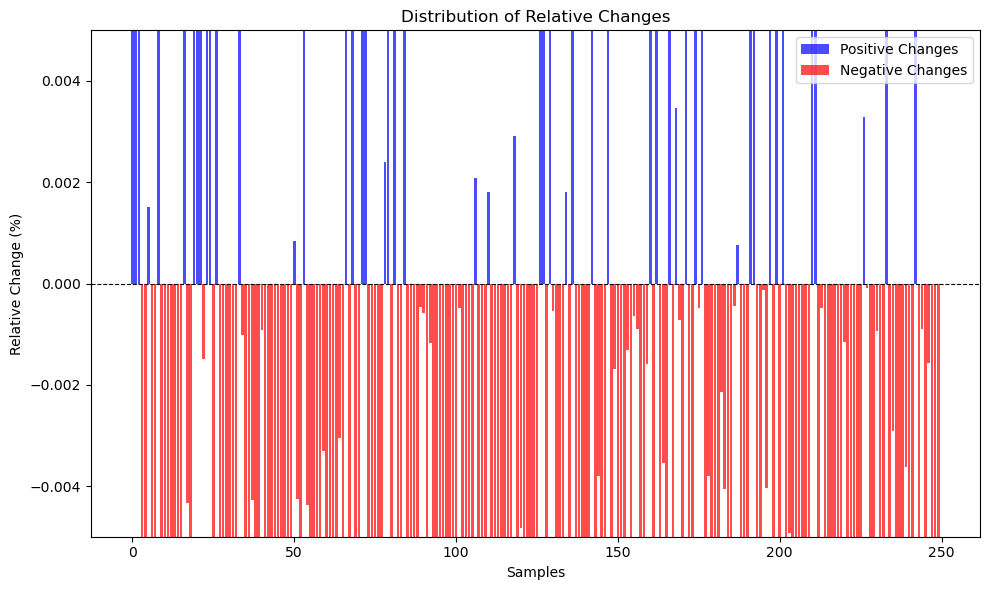


Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.724
Overall Relative Change (ORC) positive changes      :  9.616 %
Overall Relative Change (ORC) negative changes      : -27.771 %


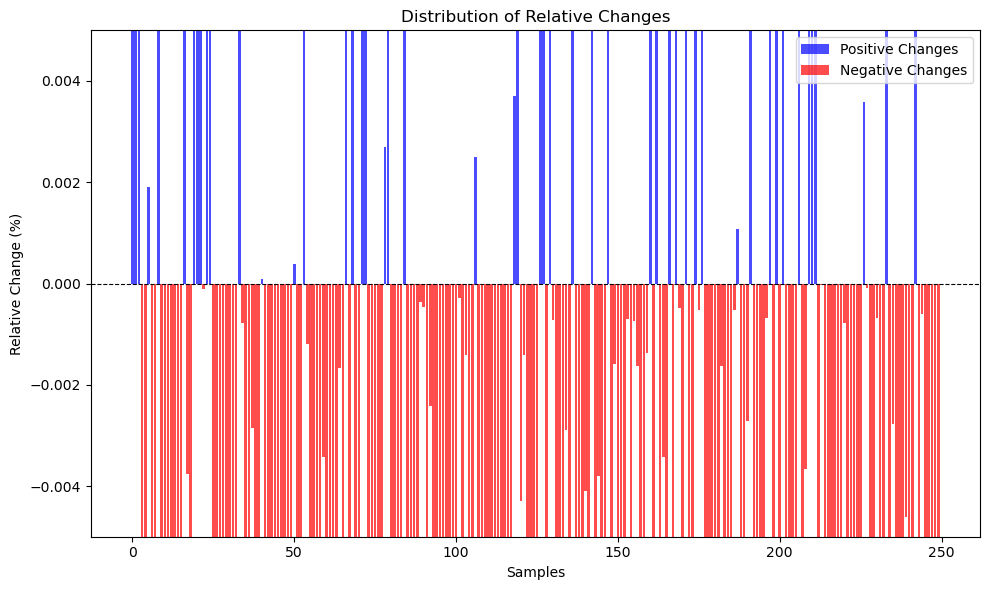


Classification accuracy                             :  0.852
Explanations Contribution Score (ECS) of Full Text  :  0.927
Explanations Contribution Score (ECS) of Top Tokens :  0.724
Overall Relative Change (ORC) positive changes      :  8.93 %
Overall Relative Change (ORC) negative changes      : -28.588 %


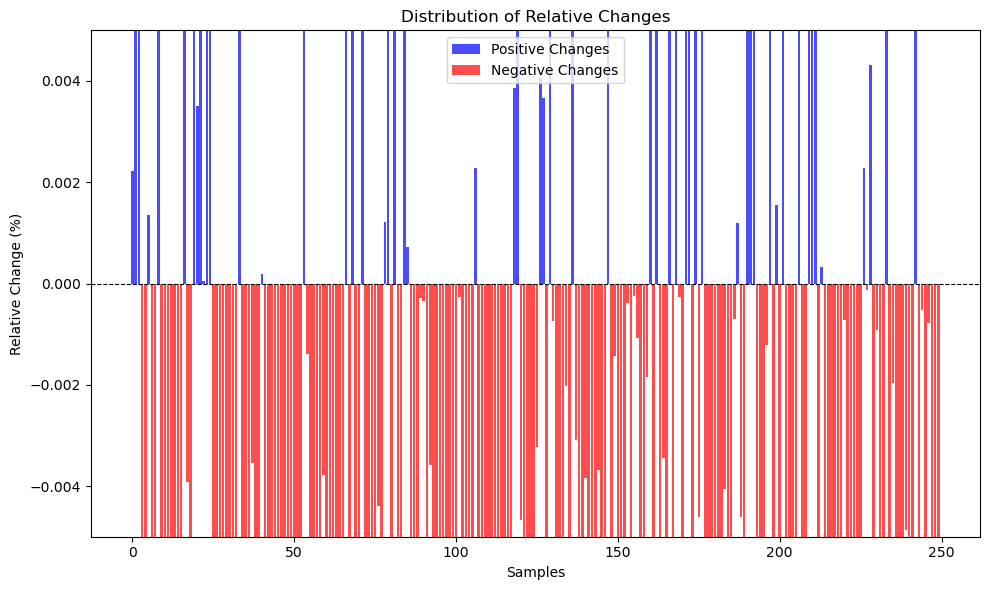

In [18]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [89]:
shap_explainer_tc32 = shap.Explainer(bert_pipeline_text_tc32)
tc32_bert_results = {}

for threshold in thresholds:

    shap_values_tc32, tokens_values_tc32 = apply_shap(path_shap, tc32_test, 
                                                      f"shap_values_tc32_{threshold}_bert", 
                                                      shap_explainer_tc32, 
                                                      len(bert_label2id_tc32),
                                                      only_load=only_load)

    top_tokens_tc32 = apply_thresholding(tokens_values_tc32, threshold)
    
    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     None,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     id2label=bert_id2label_tc32,
                                     device=device)

    tc32_bert_results[threshold] = (shap_values_tc32, tc32_bert_result)
    
    clear_gpu_memory()
    
show(tc32_bert_results[0.5][1])

'shap_values_tc32_0.5_bert' file shape: (250, None, 32)
'shap_values_tc32_0.6_bert' file shape: (250, None, 32)
'shap_values_tc32_0.7_bert' file shape: (250, None, 32)


In [20]:
# sample_no = 3

# shap.plots.text(tc32_bert_results[0.5][0][sample_no])
# shap.plots.text(tc32_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.466
Overall Relative Change (ORC) positive changes      :  4.634 %
Overall Relative Change (ORC) negative changes      : -53.661 %


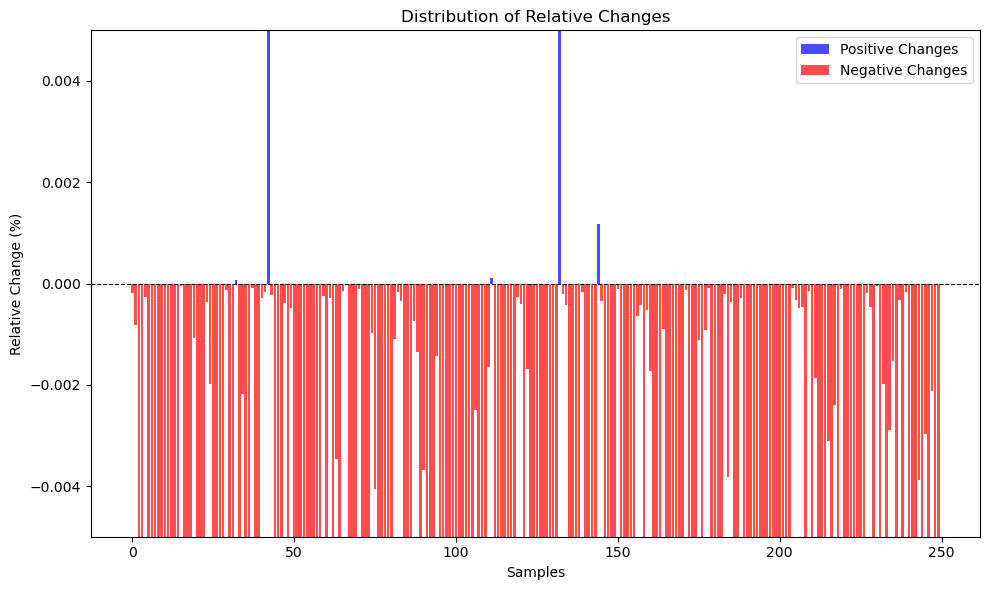


Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.466
Overall Relative Change (ORC) positive changes      :  2.948 %
Overall Relative Change (ORC) negative changes      : -54.391 %


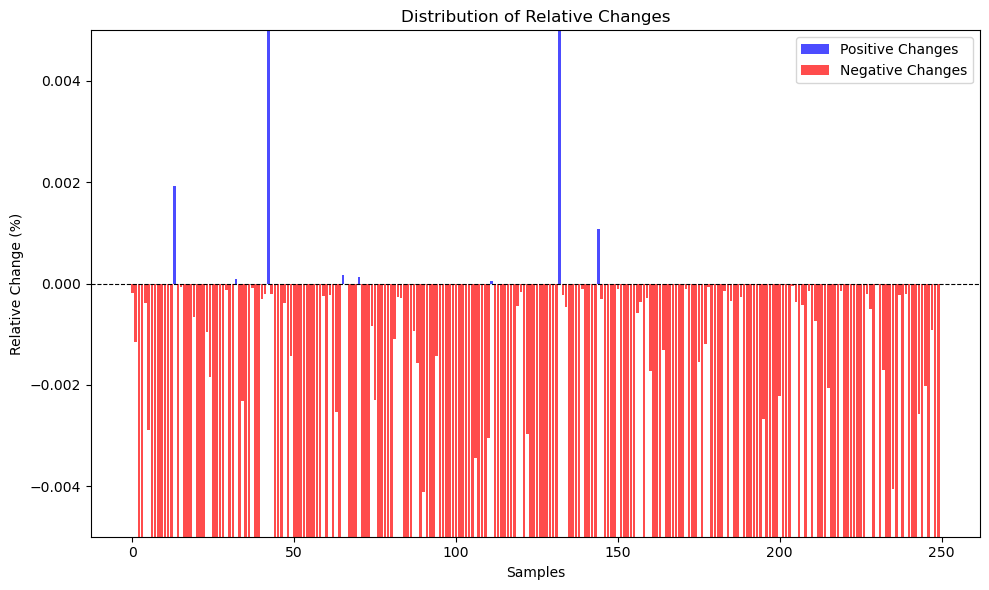


Classification accuracy                             :  0.952
Explanations Contribution Score (ECS) of Full Text  :  0.991
Explanations Contribution Score (ECS) of Top Tokens :  0.467
Overall Relative Change (ORC) positive changes      :  3.312 %
Overall Relative Change (ORC) negative changes      : -54.07 %


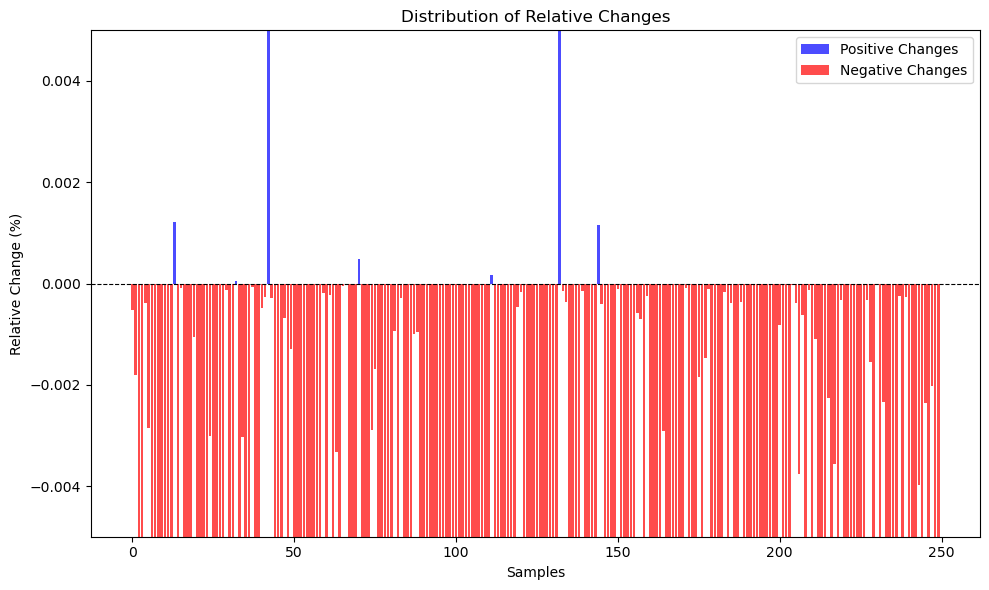

In [21]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### Inference on Full Text

In [22]:
# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)


'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


In [23]:
# predict_parameter_set_ttc4900 = {
#     'model': tbt_model_ttc4900,
#     'tokenizer': tbt_tokenizer_ttc4900,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_ttc4900,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tr_news = {
#     'model': tbt_model_tr_news,
#     'tokenizer': tbt_tokenizer_tr_news,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_tr_news,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_interpress = {
#     'model': tbt_model_interpress,
#     'tokenizer': tbt_tokenizer_interpress,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_interpress,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tc32 = {
#     'model': tbt_model_tc32,
#     'tokenizer': tbt_tokenizer_tc32,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_tc32,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# print("\nClassification metrics of full text prediction of TTC 4900:\n")
# tbt_full_text_preds_ttc4900 = evaluate_classification(ttc4900_test, predict_parameter_set_ttc4900, tbt_label2id_ttc4900)

# print("\nClassification metrics of full text prediction of TR News:\n")
# tbt_full_text_preds_tr_news = evaluate_classification(tr_news_test, predict_parameter_set_tr_news, tbt_label2id_tr_news)

# print("\nClassification metrics of full text prediction of Interpress:\n")
# tbt_full_text_preds_interpress = evaluate_classification(interpress_test, predict_parameter_set_interpress, tbt_label2id_interpress)

# print("\nClassification metrics of full text prediction of TC 32:\n")
# tbt_full_text_preds_tc32 = evaluate_classification(tc32_test, predict_parameter_set_tc32, tbt_label2id_tc32)

# path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

# with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_ttc4900, file)

# with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_tr_news, file)

# with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_interpress, file)

# with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_tc32, file)

In [24]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

In [25]:
num_samples = 250

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

#### TTC4900

In [26]:
shap_explainer_ttc4900 = shap.Explainer(tbt_pipeline_text_ttc4900)
ttc4900_tbt_results = {}

for threshold in thresholds:

    shap_values_ttc, tokens_values_ttc = apply_shap(path_shap, ttc4900_test, 
                                                    f"shap_values_ttc_{threshold}_tbt", 
                                                    shap_explainer_ttc4900, 
                                                    len(tbt_label2id_ttc4900),
                                                    only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(tokens_values_ttc, threshold)
    
    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       None,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       id2label=tbt_id2label_ttc4900,
                                       device=device)

    ttc4900_tbt_results[threshold] = (shap_values_ttc, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
show(ttc4900_tbt_results[0.5][1])

'shap_values_ttc_0.5_tbt' file shape: (250, None, 7)


'shap_values_ttc_0.6_tbt' file shape: (250, None, 7)


'shap_values_ttc_0.7_tbt' file shape: (250, None, 7)


In [27]:
# sample_no = 4

# shap.plots.text(ttc4900_tbt_results[0.7][0][sample_no])
# shap.plots.text(ttc4900_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.81
Overall Relative Change (ORC) positive changes      :  2.727 %
Overall Relative Change (ORC) negative changes      : -24.497 %


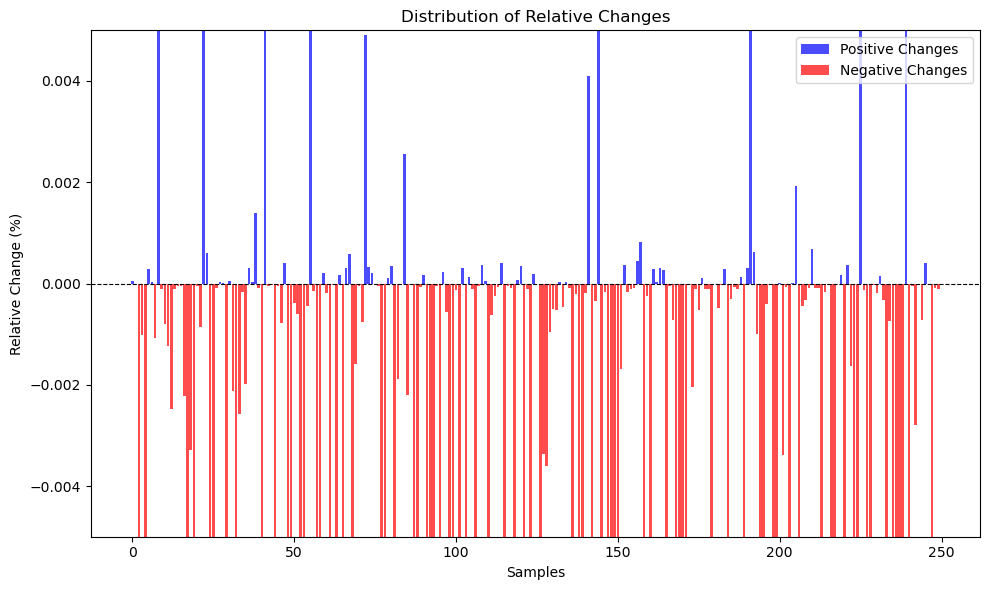


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.816
Overall Relative Change (ORC) positive changes      :  2.624 %
Overall Relative Change (ORC) negative changes      : -23.462 %


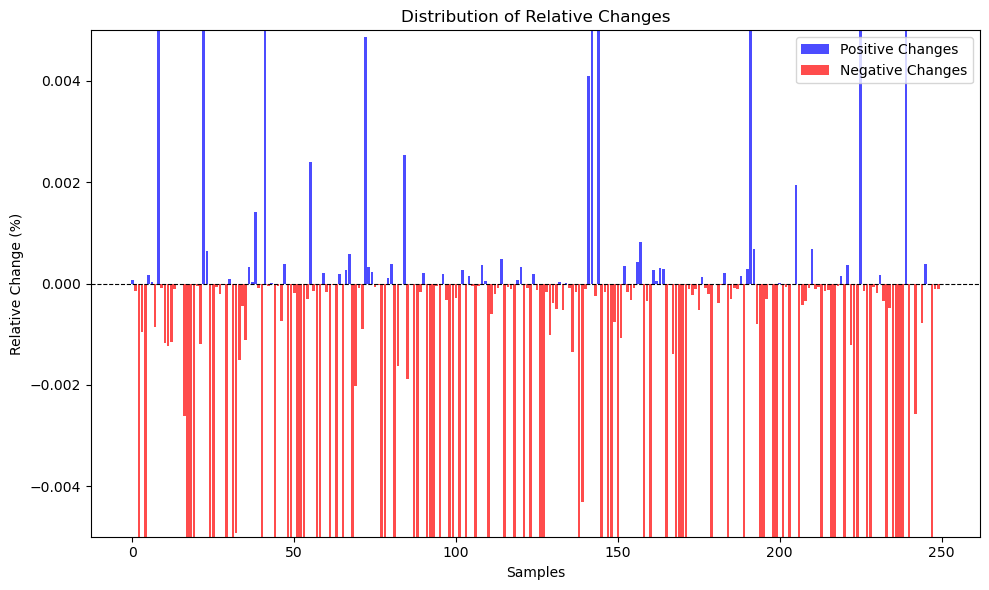


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.987
Explanations Contribution Score (ECS) of Top Tokens :  0.799
Overall Relative Change (ORC) positive changes      :  1.611 %
Overall Relative Change (ORC) negative changes      : -25.105 %


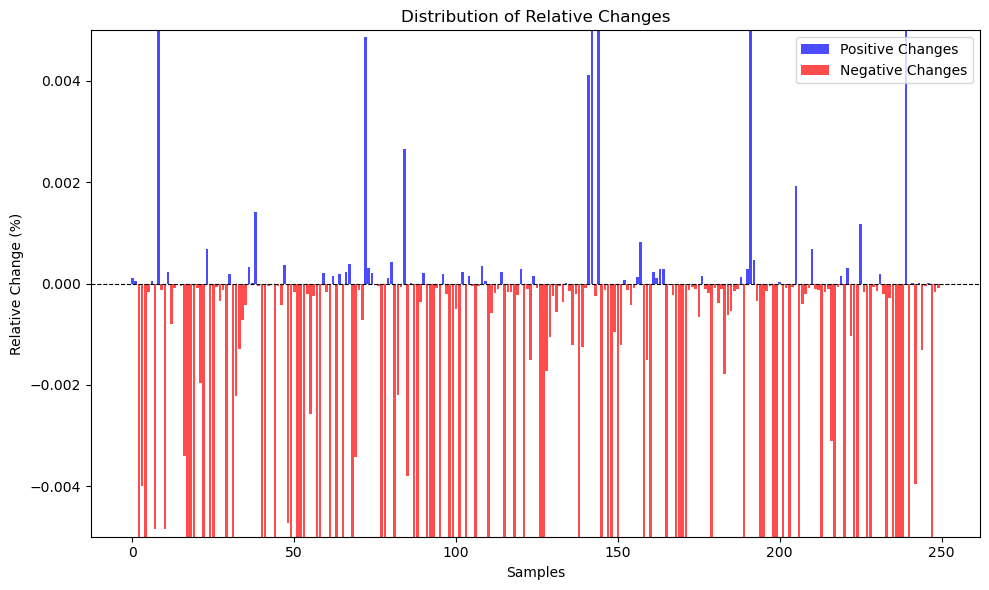

In [28]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [29]:
shap_explainer_tr_news = shap.Explainer(tbt_pipeline_text_tr_news)
tr_news_tbt_results = {}

for threshold in thresholds:

    shap_values_tr_news, tokens_values_tr_news = apply_shap(path_shap, tr_news_test, 
                                                            f"shap_values_tr_news_{threshold}_tbt", 
                                                            shap_explainer_tr_news,
                                                            len(tbt_label2id_tr_news),
                                                            only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(tokens_values_tr_news, threshold)
    
    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       None,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       id2label=tbt_id2label_tr_news,
                                       device=device)

    tr_news_tbt_results[threshold] = (shap_values_tr_news, tr_news_tbt_result)
    
    clear_gpu_memory()
    
show(tr_news_tbt_results[0.5][1])

'shap_values_tr_news_0.5_tbt' file shape: (250, None, 11)


'shap_values_tr_news_0.6_tbt' file shape: (250, None, 11)


'shap_values_tr_news_0.7_tbt' file shape: (250, None, 11)


In [30]:
# sample_no = 4

# shap.plots.text(tr_news_tbt_results[0.7][0][sample_no])
# shap.plots.text(tr_news_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.438
Overall Relative Change (ORC) positive changes      :  9.041 %
Overall Relative Change (ORC) negative changes      : -42.863 %


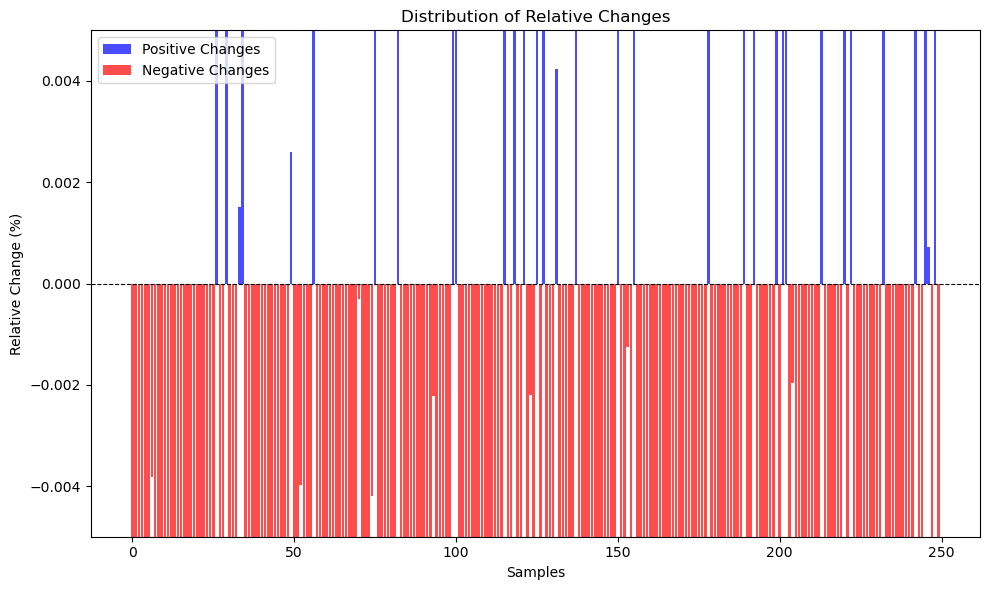


Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.425
Overall Relative Change (ORC) positive changes      :  8.792 %
Overall Relative Change (ORC) negative changes      : -44.149 %


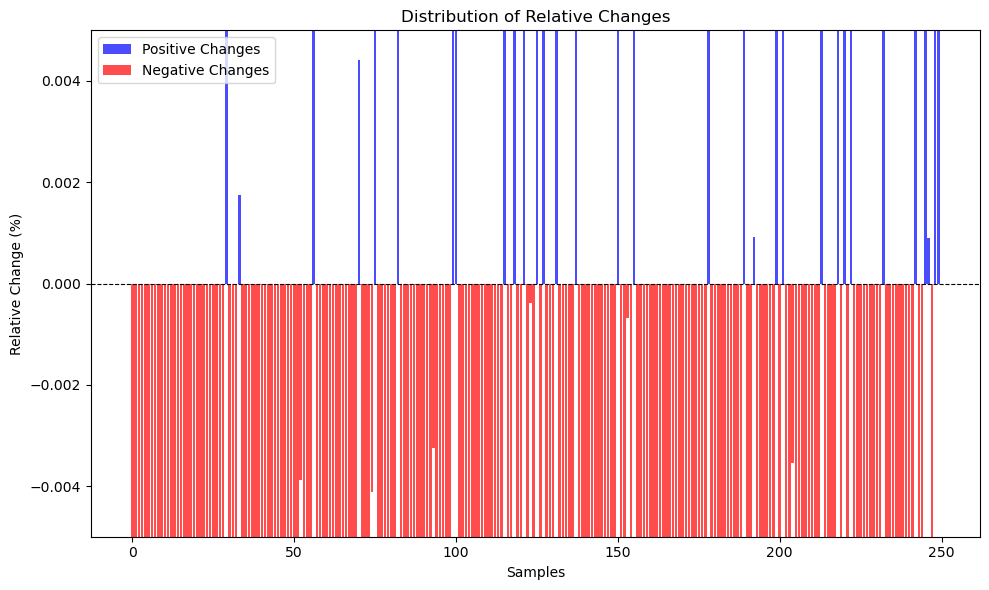


Classification accuracy                             :  0.712
Explanations Contribution Score (ECS) of Full Text  :  0.798
Explanations Contribution Score (ECS) of Top Tokens :  0.419
Overall Relative Change (ORC) positive changes      :  9.868 %
Overall Relative Change (ORC) negative changes      : -45.226 %


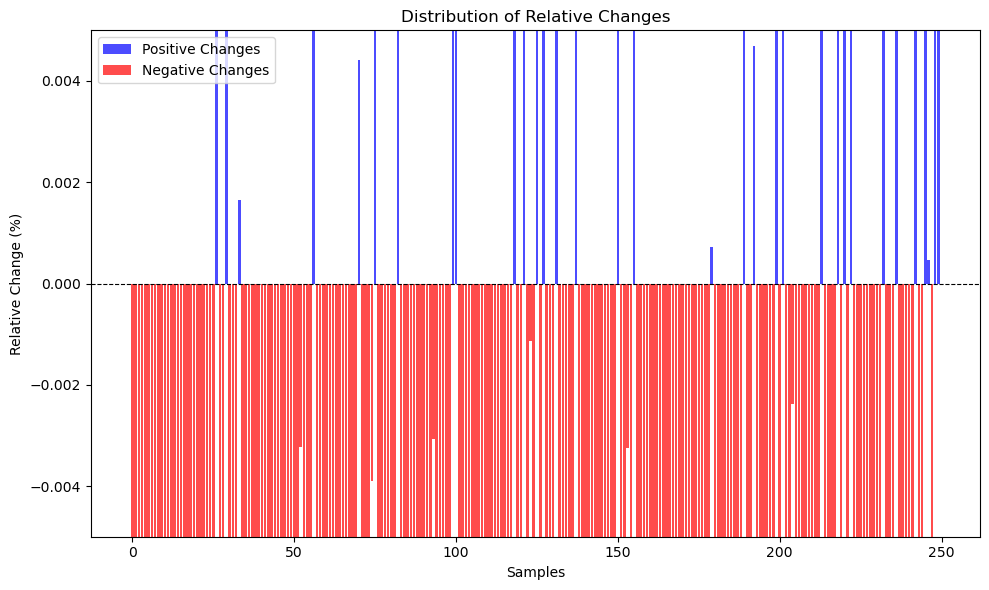

In [31]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [32]:
shap_explainer_interpress = shap.Explainer(tbt_pipeline_text_interpress)
interpress_tbt_results = {}

for threshold in thresholds:

    shap_values_interpress, tokens_values_interpress = apply_shap(path_shap, interpress_test, 
                                                                  f"shap_values_interpress_{threshold}_tbt", 
                                                                  shap_explainer_interpress,
                                                                  len(tbt_label2id_interpress),
                                                                  only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(tokens_values_interpress, threshold)
    
    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          None,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          id2label=tbt_id2label_interpress,
                                          device=device)

    interpress_tbt_results[threshold] = (shap_values_interpress, interpress_tbt_result)
    
    clear_gpu_memory()
    
show(interpress_tbt_results[0.5][1])

'shap_values_interpress_0.5_tbt' file shape: (250, None, 10)


'shap_values_interpress_0.6_tbt' file shape: (250, None, 10)


'shap_values_interpress_0.7_tbt' file shape: (250, None, 10)


In [33]:
# sample_no = 23

# shap.plots.text(interpress_tbt_results[0.7][0][sample_no])
# shap.plots.text(interpress_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.322
Overall Relative Change (ORC) positive changes      :  13.558 %
Overall Relative Change (ORC) negative changes      : -62.627 %


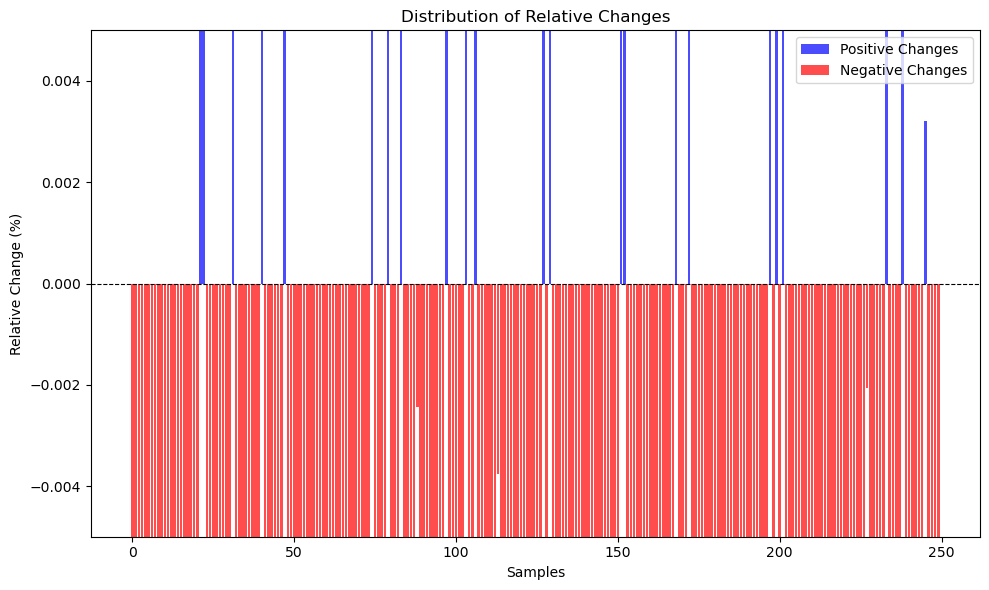


Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.334
Overall Relative Change (ORC) positive changes      :  13.412 %
Overall Relative Change (ORC) negative changes      : -62.001 %


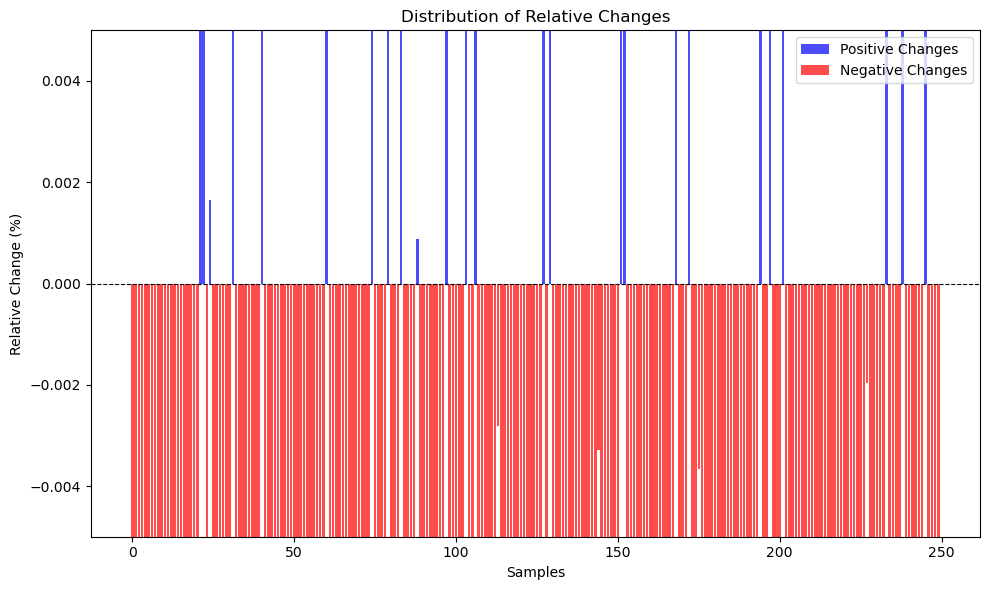


Classification accuracy                             :  0.764
Explanations Contribution Score (ECS) of Full Text  :  0.878
Explanations Contribution Score (ECS) of Top Tokens :  0.357
Overall Relative Change (ORC) positive changes      :  13.449 %
Overall Relative Change (ORC) negative changes      : -60.029 %


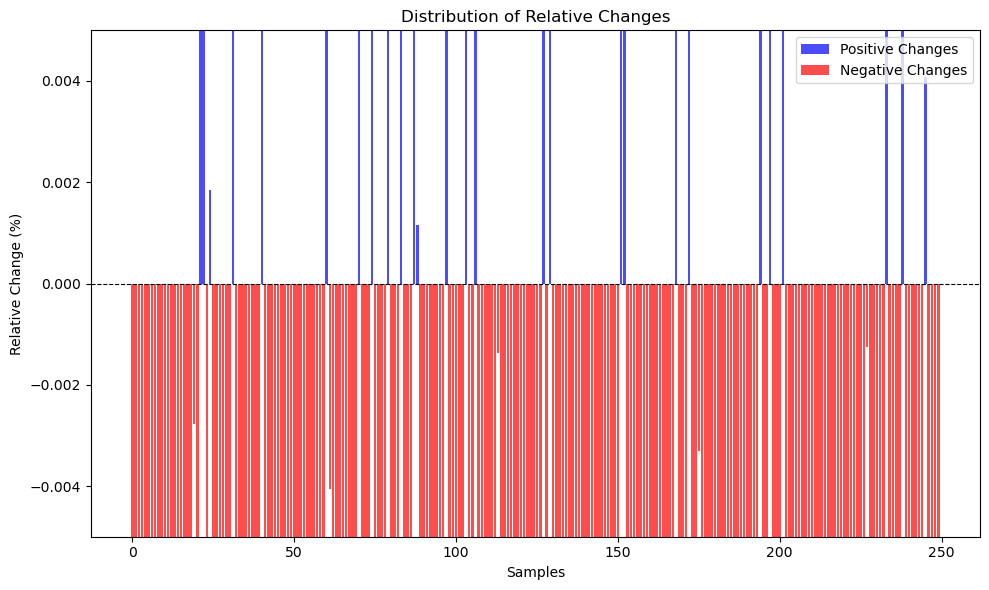

In [34]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [35]:
shap_explainer_tc32 = shap.Explainer(tbt_pipeline_text_tc32)
tc32_tbt_results = {}

for threshold in thresholds:

    shap_values_tc32, tokens_values_tc32 = apply_shap(path_shap, tc32_test, 
                                                      f"shap_values_tc32_{threshold}_tbt", 
                                                      shap_explainer_tc32, 
                                                      len(tbt_label2id_tc32),
                                                      only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(tokens_values_tc32, threshold)
    
    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    None,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    id2label=tbt_id2label_tc32,
                                    device=device)

    tc32_tbt_results[threshold] = (shap_values_tc32, tc32_tbt_result)
    
    clear_gpu_memory()
    
show(tc32_tbt_results[0.5][1])

'shap_values_tc32_0.5_tbt' file shape: (250, None, 32)


'shap_values_tc32_0.6_tbt' file shape: (250, None, 32)


'shap_values_tc32_0.7_tbt' file shape: (250, None, 32)


In [36]:
# sample_no = 15

# shap.plots.text(tc32_tbt_results[0.7][0][sample_no])
# shap.plots.text(tc32_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.152
Overall Relative Change (ORC) positive changes      :  1.932 %
Overall Relative Change (ORC) negative changes      : -82.773 %


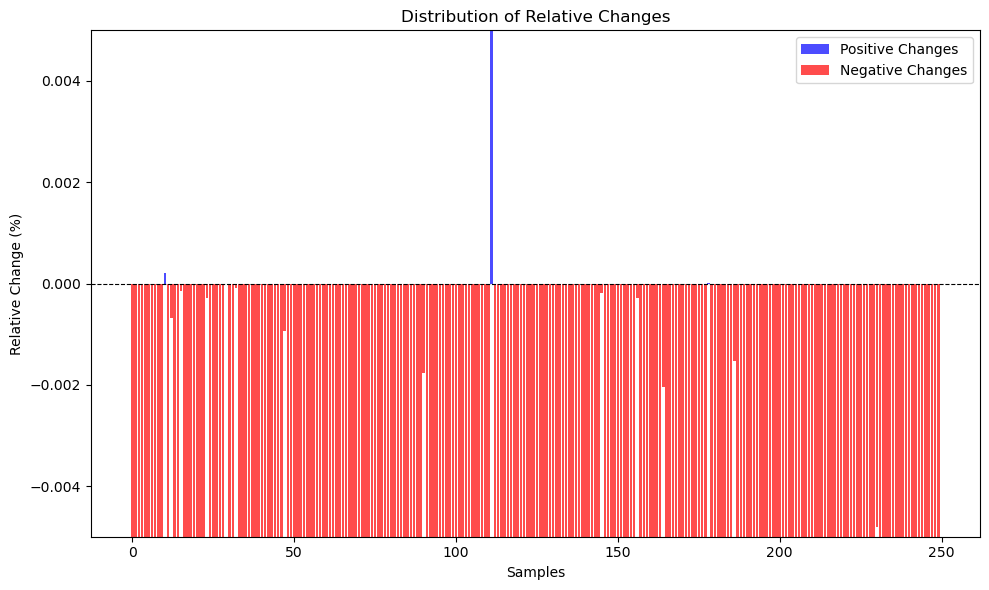


Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.161
Overall Relative Change (ORC) positive changes      :  1.941 %
Overall Relative Change (ORC) negative changes      : -81.88 %


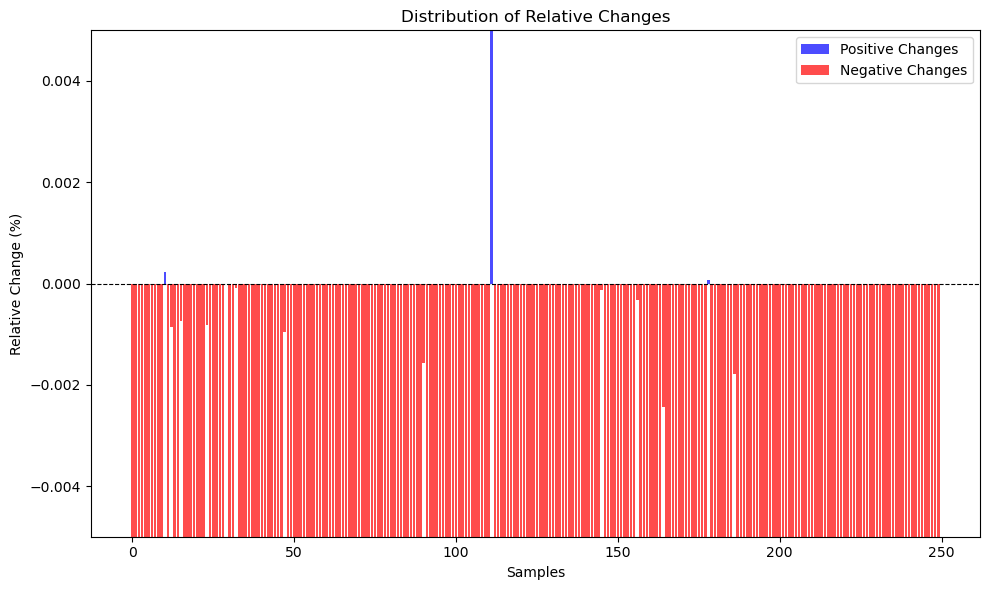


Classification accuracy                             :  0.912
Explanations Contribution Score (ECS) of Full Text  :  0.97
Explanations Contribution Score (ECS) of Top Tokens :  0.165
Overall Relative Change (ORC) positive changes      :  1.465 %
Overall Relative Change (ORC) negative changes      : -81.827 %


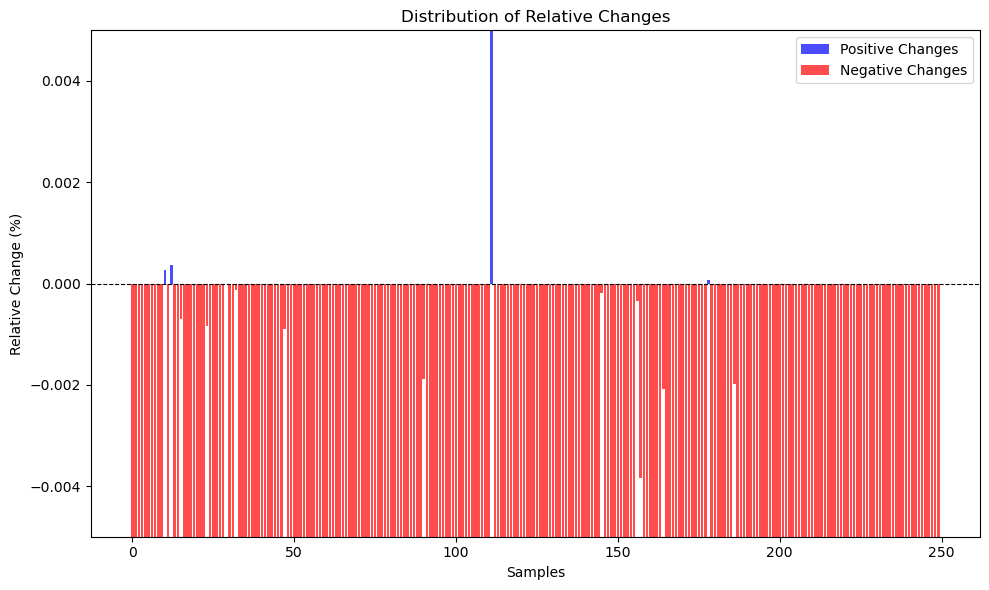

In [37]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

## Final Results

In [38]:
all_exp_results

Cl Acc  ECS FT  ECS TT  ORC (+)  ORC (-)
0    0.900   0.973   0.906    5.821   -9.636
1    0.900   0.973   0.915    6.002   -8.869
2    0.900   0.973   0.919    5.532   -8.622
3    0.776   0.856   0.562   11.465  -35.581
4    0.776   0.856   0.562   11.887  -35.431
5    0.776   0.856   0.541   12.502  -37.786
6    0.852   0.927   0.731    8.681  -26.824
7    0.852   0.927   0.724    9.616  -27.771
8    0.852   0.927   0.724    8.930  -28.588
9    0.952   0.991   0.466    4.634  -53.661
10   0.952   0.991   0.466    2.948  -54.391
11   0.952   0.991   0.467    3.312  -54.070
12   0.900   0.987   0.810    2.727  -24.497
13   0.900   0.987   0.816    2.624  -23.462
14   0.900   0.987   0.799    1.611  -25.105
15   0.712   0.798   0.438    9.041  -42.863
16   0.712   0.798   0.425    8.792  -44.149
17   0.712   0.798   0.419    9.868  -45.226
18   0.764   0.878   0.322   13.558  -62.627
19   0.764   0.878   0.334   13.412  -62.001
20   0.764   0.878   0.357   13.449  -60.029
21   0.912   0.970   0.152    1.932  -82.773
22   0.912   0.970   0.161    1.941  -81.880
23   0.912   0.970   0.165    1.465  -81.827

In [39]:
excel_file = path_reports + 'all_exp_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    all_exp_results.to_excel(writer, sheet_name='SHAP', index=False)